# Risk forecasting DNN model

In [2]:
# if running through colab, install yfinance
!pip3 install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

import yfinance as yf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, GRU, Bidirectional

from sklearn.model_selection import train_test_split

In [4]:
SERIES_PERIOD = '10y'
SERIES_INTERVAL = '1d'

DATA_VARIABLES = 'univariate'
LOOKBACK_WINDOW = 10
PREDICTION_LEN = 1
TRAIN_TEST_SPLIT = 0.9

EPOCHS = 10
BATCH_SIZE = 32

### Dataset

In [5]:
# fetch closing values
sp500 = '^GSPC'

sp500_data = yf.Ticker(sp500)
sp500_history = sp500_data.history(period=SERIES_PERIOD, interval=SERIES_INTERVAL)
close = sp500_history.Close.loc[sp500_history.Close != 0][:-1]

# compute logarithmic returns
log_returns = np.log(close) - np.log(close.shift(1))
log_returns.dropna(inplace=True)

# fetch VIX volatility data
vix = '^VIX'
vix_data = yf.Ticker(vix)
vix_history = vix_data.history(period=SERIES_PERIOD, interval=SERIES_INTERVAL)
vix_close = vix_history.Close.loc[vix_history.Close != 0][:-1]

# compute numerical volitility as standard deviation over 5-point rolling window
volatility = close.pct_change().rolling(5).std()

# gather other variables
_open = sp500_history.Open[:-1]
_high = sp500_history.High[:-1]
_low = sp500_history.Low[:-1]
_volume = sp500_history.Volume[:-1]

# generate dataframe of closing prices and log returns
X = pd.DataFrame({
    'open': (_open - _open.mean()) / _open.std(),
    'high': (_high - _high.mean()) / _high.std(),
    'low': (_low - _low.mean()) / _low.std(),
    'volume': (_volume - _volume.mean()) / _volume.std(),

    'close': (close - close.mean()) / close.std(),
    'returns': (log_returns) / log_returns.std(),  # already centred about 0
    'vix': (vix_close - vix_close.mean()) / vix_close.std(),
    'volatility': (volatility - volatility.mean()) / volatility.std()
})

# remove NaN values and normalise
X.dropna(inplace=True)
X = X[list(X)].astype(np.float64)
X

,open,high,low,volume,close,returns,vix,volatility
Date,,,,,,,,
2012-06-15,-1.453808,-1.443670,-1.447800,0.742237,-1.439006,0.962015,0.526643,0.467664
2012-06-18,-1.438683,-1.438104,-1.441731,-0.511769,-1.436787,0.135041,0.132879,-0.010410
2012-06-19,-1.435928,-1.420793,-1.429789,0.098600,-1.421694,0.913664,0.141347,-0.054253
2012-06-20,-1.420827,-1.422940,-1.427923,-0.032769,-1.424313,-0.157872,-0.019546,-0.325160
2012-06-21,-1.423810,-1.426688,-1.453305,0.405058,-1.458821,-2.105842,0.381275,0.704244
...,...,...,...,...,...,...,...,...
2022-06-01,1.770642,1.763309,1.713006,0.461317,1.715003,-0.702556,1.173037,0.908207
2022-06-02,1.708487,1.775770,1.713605,-0.132430,1.801434,1.708307,1.036137,1.011002
2022-06-03,1.756684,1.736195,1.741589,-0.679041,1.723361,-1.541732,1.046017,1.347878


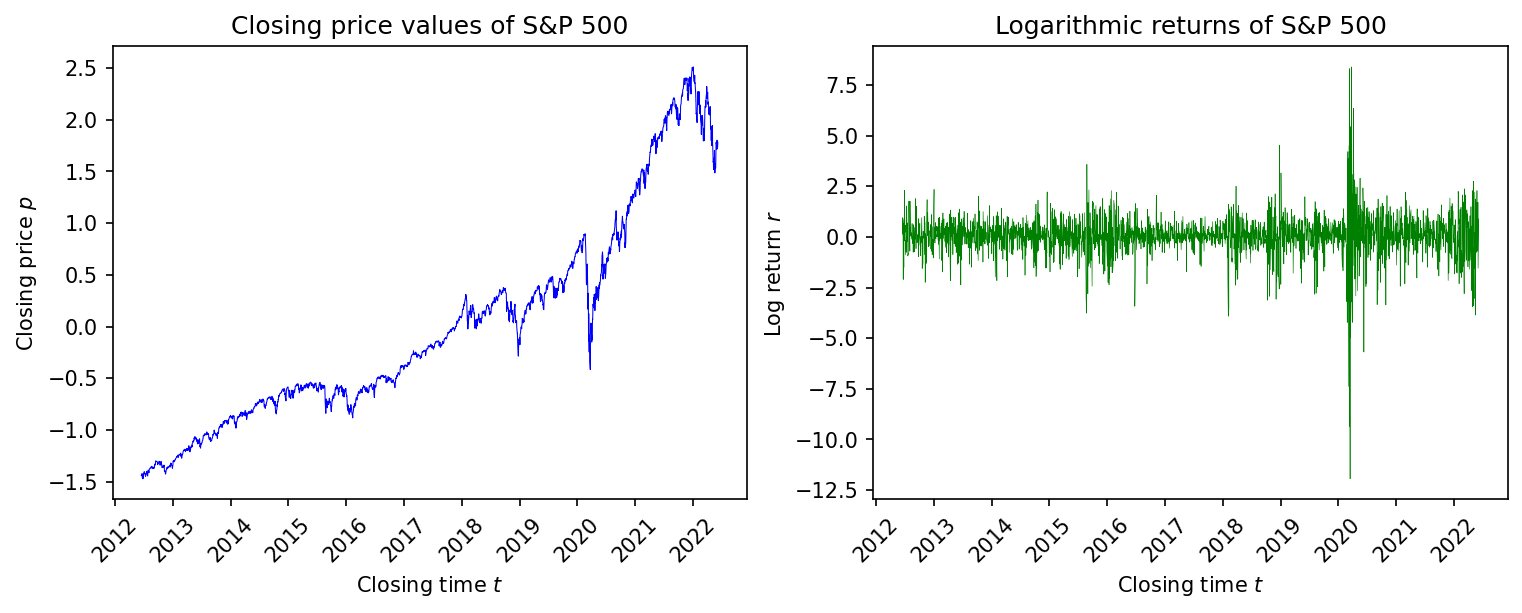

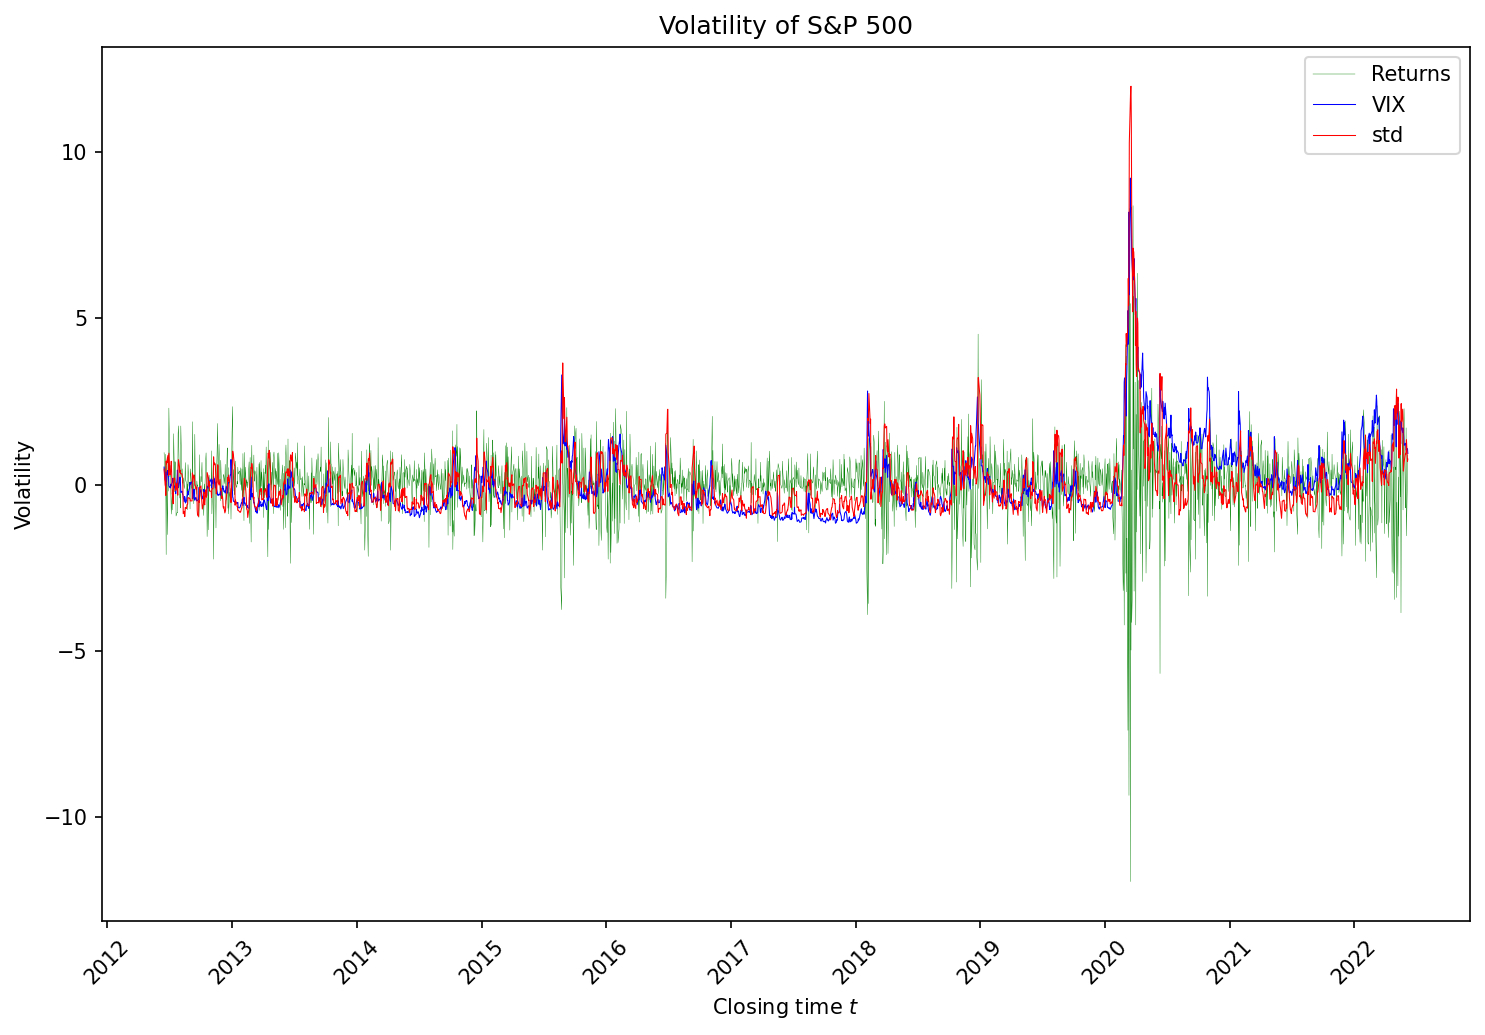

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=150)

ax[0].plot(X.close, linewidth=0.5, color='b')
ax[0].set(title=f'Closing price values of S&P 500', xlabel=r'Closing time $t$', ylabel=r'Closing price $p$')
ax[0].tick_params(axis='x', rotation=45)

ax[1].plot(X.returns, linewidth=0.3, color='g')
ax[1].set(title=f'Logarithmic returns of S&P 500', xlabel=r'Closing time $t$', ylabel=r'Log return $r$')
ax[1].tick_params(axis='x', rotation=45)

fig, ax = plt.subplots(figsize=(10, 7), dpi=150)
ax.plot(X.returns, linewidth=0.2, color='g', label='Returns')
ax.plot(X.vix, linewidth=0.5, color='b', label='VIX')
ax.plot(X.volatility, linewidth=0.5, color='r', label='std')
ax.set(title=f'Volatility of S&P 500', xlabel=r'Closing time $t$', ylabel=r'Volatility')
ax.tick_params(axis='x', rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

In [7]:
# build dataset:
#   each instance consists of a `LOOKBACK_WINDOW` length time series (prev `LOOKBACK_WINDOW`) over variables
#   each label is the VIX value that comes at the next timestep after this series
X_data = []
y_data = []

if DATA_VARIABLES == 'univariate':

    print("Univariate data")
    for i in range(X.vix.shape[0] - LOOKBACK_WINDOW - PREDICTION_LEN + 1):
        X_data.append(X.vix[i: i + LOOKBACK_WINDOW])
        y_data.append(X.vix[i + LOOKBACK_WINDOW: i + LOOKBACK_WINDOW + PREDICTION_LEN])

    # convert X to numpy
    X_data = np.array(X_data)
    X_data = np.expand_dims(X_data, 2)

elif DATA_VARIABLES == 'multivariate':

    print("Multivariate data")
    for i in range(X.shape[0] - LOOKBACK_WINDOW):
        X_data.append((
            X.open[i: i + LOOKBACK_WINDOW],
            X.high[i: i + LOOKBACK_WINDOW],
            X.low[i: i + LOOKBACK_WINDOW],
            X.volume[i: i + LOOKBACK_WINDOW],
            X.close[i: i + LOOKBACK_WINDOW],
            X.returns[i: i + LOOKBACK_WINDOW],
            X.vix[i: i + LOOKBACK_WINDOW],
            X.volatility[i: i + LOOKBACK_WINDOW],
        ))
        y_data.append(X.vix[i + LOOKBACK_WINDOW])

    # convert X to numpy
    X_data = np.array(X_data)

else:
    exit(1)

# convert y to numpy
y_data = np.array(y_data)

# split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=(1 - TRAIN_TEST_SPLIT), shuffle=False)

# train_test_split = math.floor(X_data.shape[0] * TRAIN_TEST_SPLIT)

# X_test = X_data[train_test_split:]
# y_test = y_data[train_test_split:]

# X_train_raw = X_data[:train_test_split]
# y_train_raw = y_data[:train_test_split]

# # shuffle X and y in unision
# X_train = np.empty(X_train_raw.shape, dtype=X_train_raw.dtype)
# y_train = np.empty(y_train_raw.shape, dtype=y_train_raw.dtype)
# perm = np.random.permutation(X_train_raw.shape[0])

# for i_old, i_new in enumerate(perm):
#     X_train[i_new] = X_train_raw[i_old]
#     y_train[i_new] = y_train_raw[i_old]

print(X_train.shape, y_train.shape, '\n', X_test.shape, y_test.shape)

Univariate data
(2250, 10, 1) (2250, 1) 
 (251, 10, 1) (251, 1)


In [8]:
# build RNN comprising of one LSTM layer and one FCN layer
rnn_model = Sequential([
    SimpleRNN(256, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:])),
    SimpleRNN(256, activation='tanh'),
    Dense(1, activation='linear')
])

gru_model = Sequential([
    GRU(256, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:])),
    GRU(256, activation='tanh'),
    Dense(1, activation='linear')
])

lstm_model = Sequential([
    LSTM(256, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:])),
    LSTM(256, activation='tanh'),
    Dense(1, activation='linear')
])

bidir_model = Sequential([
    Bidirectional(
        LSTM(256, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:]))
    ),
    Bidirectional(
        LSTM(256, activation='tanh')
    ),
    Dense(1, activation='linear')
])

# models = {
#     'rnn': rnn_model, 
#     'gru': gru_model, 
#     'lstm': lstm_model, 
#     'bidir': bidir_model
# }
models = {
    'lstm': lstm_model
}

for model in models.values():
    model.compile(loss='mae', optimizer='adam', metrics=['mse'])

In [9]:
histories = {}
for m in range(len(models)):
    model = list(models.values())[m]
    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
    histories.update({list(models.keys())[m]: history.history})

Epoch 1/10
71/71 [==============================] - 8s 6ms/step - loss: 0.2407 - mse: 0.1683
Epoch 2/10
71/71 [==============================] - 0s 5ms/step - loss: 0.1847 - mse: 0.0985
Epoch 3/10
71/71 [==============================] - 0s 6ms/step - loss: 0.1593 - mse: 0.0763
Epoch 4/10
71/71 [==============================] - 0s 5ms/step - loss: 0.1505 - mse: 0.0715
Epoch 5/10
71/71 [==============================] - 0s 5ms/step - loss: 0.1490 - mse: 0.0718
Epoch 6/10
71/71 [==============================] - 0s 6ms/step - loss: 0.1482 - mse: 0.0728
Epoch 7/10
71/71 [==============================] - 0s 6ms/step - loss: 0.1455 - mse: 0.0693
Epoch 8/10
71/71 [==============================] - 0s 6ms/step - loss: 0.1463 - mse: 0.0690
Epoch 9/10
71/71 [==============================] - 0s 6ms/step - loss: 0.1455 - mse: 0.0684
Epoch 10/10
71/71 [==============================] - 0s 6ms/step - loss: 0.1456 - mse: 0.0678


In [15]:
predictions = {}
metrics = {}
for m in range(len(models.values())):
    model = list(models.values())[m]
    prediction = lstm_model.predict(X_test)

    mae = np.abs(np.subtract(y_test, prediction)).mean()
    mse = np.square(np.subtract(y_test, prediction)).mean()
    msle = np.square(np.subtract(np.log(y_test + 1), np.log(prediction + 1))).mean()
    mape = np.abs((y_test - prediction) / y_test).mean() * 100

    metrics.update({
        list(models.keys())[m]: {
            'mae': mae,
            'mse': mse,
            'msle': msle,
            'mape': mape
        }
    })

    predictions.update({
        list(models.keys())[m]: {
            'scaled': prediction,
            'unscaled': prediction * vix_close.std() + vix_close.mean()
        }
    })

    print(f" - {list(models.keys())[m]}: \n\t mae = {mae:.5f}; mse = {mse:.5f}; msle = {msle:.5f}; mape = {mape:.5f}%")


x = 2
y = len(metrics) % x

 - lstm: 
	 mae = 0.20190; mse = 0.08186; msle = 0.02924; mape = 71.71847%


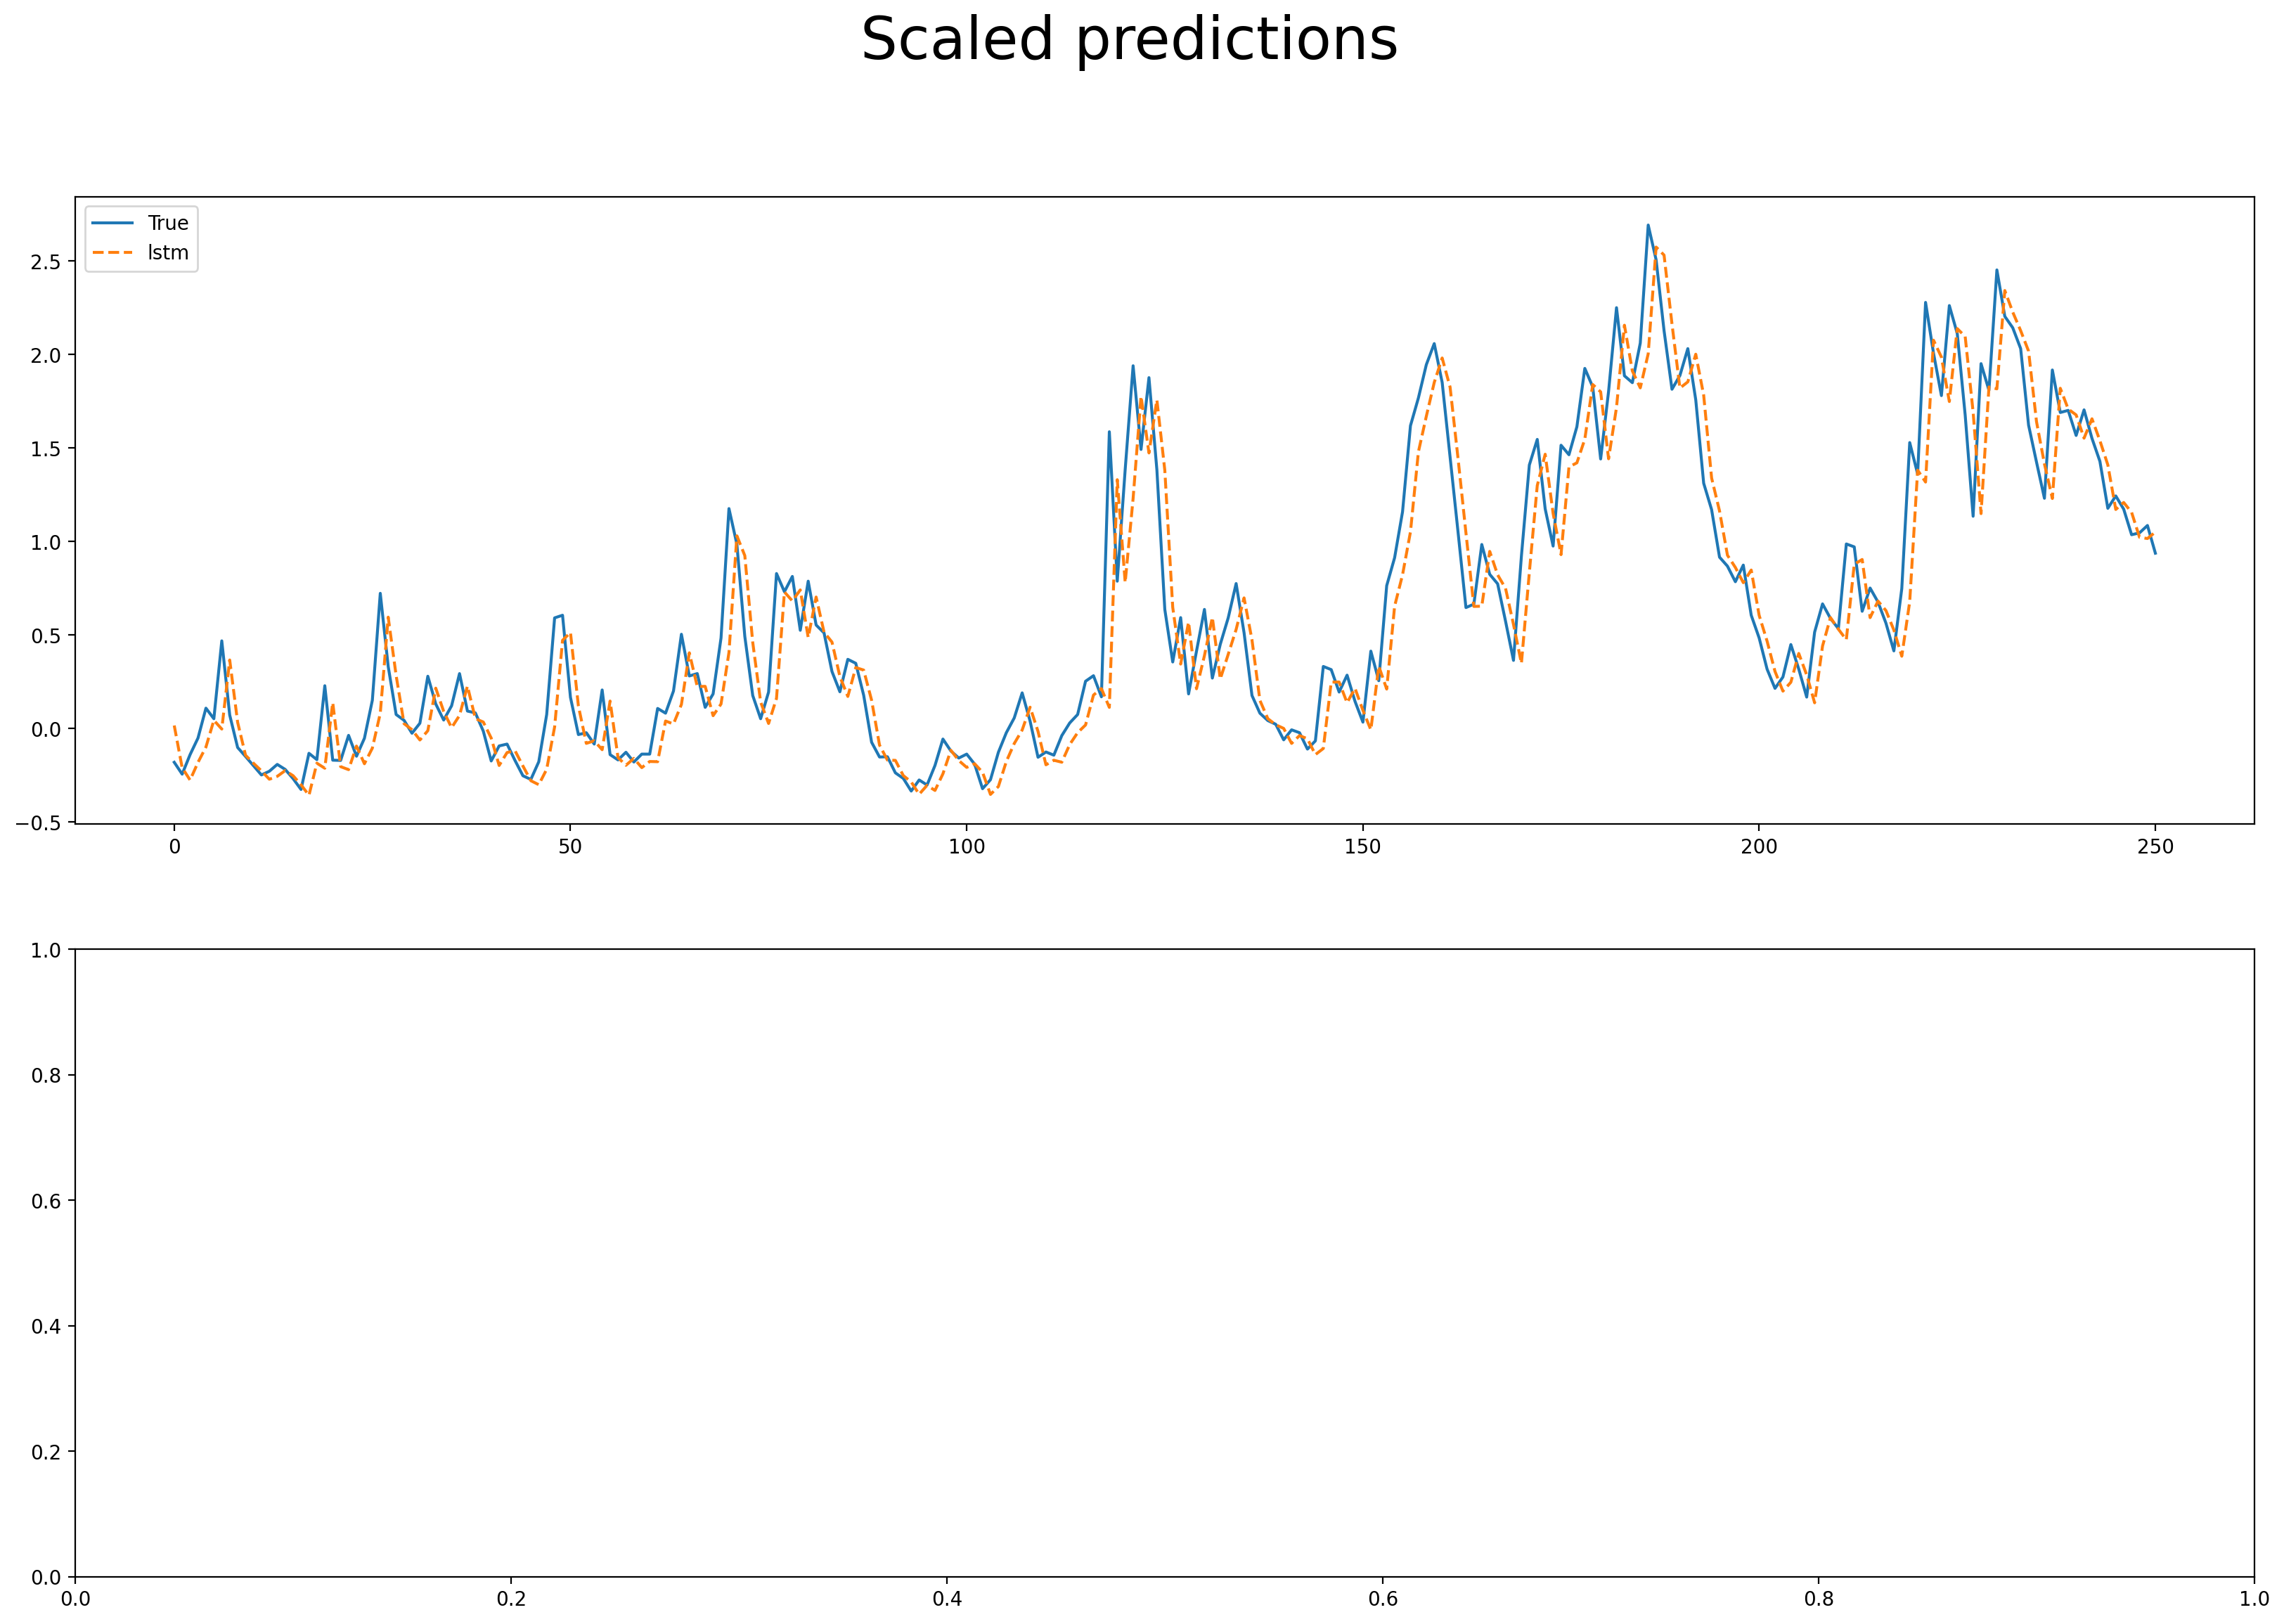

In [43]:
fig, ax = plt.subplots(x, y, figsize=(10 * x, 13*y), dpi=200)
fig.suptitle("Scaled predictions", fontsize=30)

ind = 0
if y > 1 and x > 1:
    for _y in range(y):
        for _x in range(x):
            if (_y * x + _x) < len(metrics):
                ax[_x, _y].plot(y_test, label='True')
                ax[_x, _y].plot(predictions[list(metrics.keys())[ind]]['scaled'], linestyle='--', label=list(metrics.keys())[ind])
                ax[_x, _y].legend(loc=2)
                ind += 1
else:
    for _x in range(x):
        if _x < len(metrics):
            ax[_x].plot(y_test, label='True')
            ax[_x].plot(predictions[list(metrics.keys())[_x]]['scaled'], linestyle='--', label=list(metrics.keys())[_x])
            ax[_x].legend(loc=2)

plt.show()

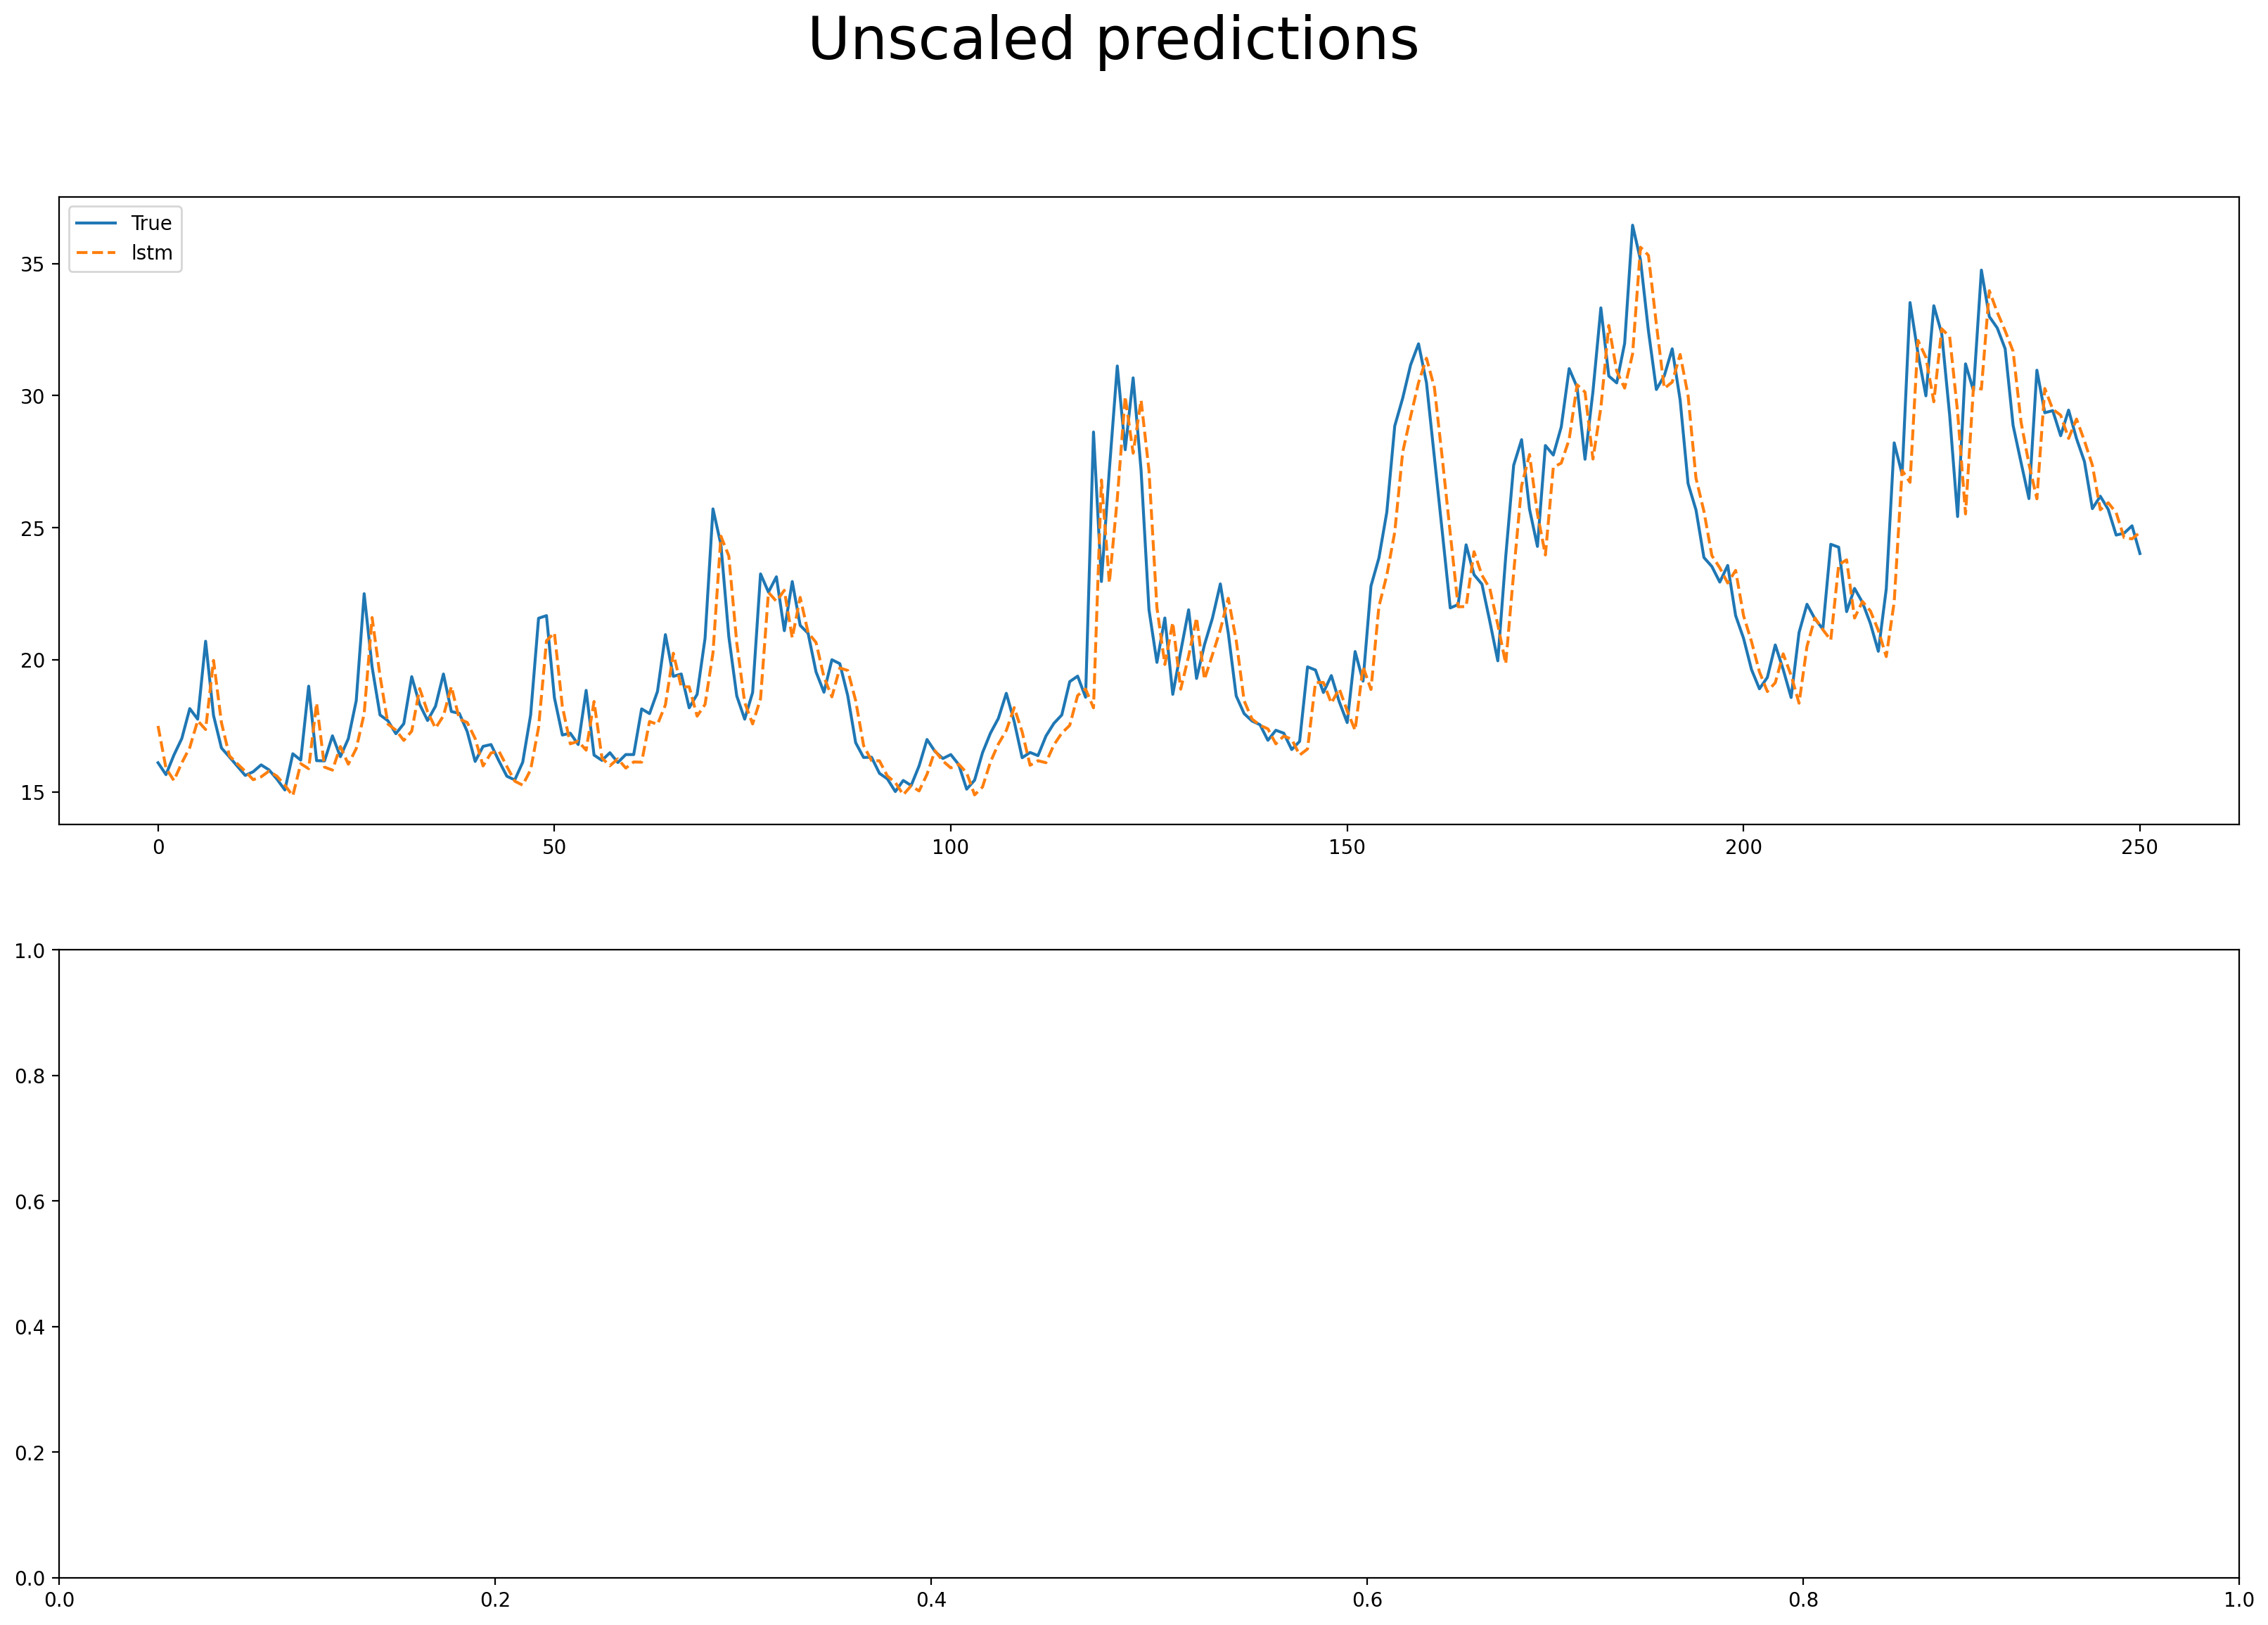

In [51]:
y_test_unscaled = y_test * vix_close.std() + vix_close.mean()

fig, ax = plt.subplots(x, y, figsize=(10 * x, 13*y), dpi=200)
fig.suptitle("Unscaled predictions", fontsize=30)

ind = 0
if y > 1 and x > 1:
    for _y in range(y):
        for _x in range(x):
            if (_y * x + _x) < len(metrics):
                ax[_x, _y].plot(y_test_unscaled, label='True')
                ax[_x, _y].plot(predictions[list(metrics.keys())[ind]]['unscaled'], linestyle='--', label=list(metrics.keys())[ind])
                ax[_x, _y].legend(loc=2)
                ind += 1
else:
    for _x in range(x):
        if _x < len(metrics):
            ax[_x].plot(y_test_unscaled, label='True')
            ax[_x].plot(predictions[list(metrics.keys())[_x]]['unscaled'], linestyle='--', label=list(metrics.keys())[_x])
            ax[_x].legend(loc=2)

plt.show()

### Error metrics

*Univariate:*

- RNN: 
	- mse = 0.001074650754406612; mae = 0.023033138734553867; mape = 12.91123152923138%
 - GRU: 
	- mse = 0.0007996564517214099; mae = 0.01919836468773903; mape = 10.721522533753063%
 - LSTM: 
	- mse = 0.000811033351244647; mae = 0.01918201674848624; mape = 10.663131522243265%
 - Bidirectional LSTM: 
	- mse = 0.000755576708226678; mae = 0.020408566937683045; mape = 11.719401281215514%

*Multivariate:*

 - RNN: 
	- mae = 0.02606; mse = 0.00120; msle = 0.00082; mape = 15.57855%
 - GRU: 
	- mae = 0.02097; mse = 0.00080; msle = 0.00055; mape = 12.74910%
 - LSTM: 
	- mae = 0.02211; mse = 0.00087; msle = 0.00059; mape = 12.83362%
 - Bidirectional LSTM: 
	- mae = 0.02302; mse = 0.00090; msle = 0.00062; mape = 13.66875%

In [45]:
from scipy.stats import norm

# VaR prediction
def VaR(self, y, confidence_level=0.05):
    # VaR = V_p * (R_p – z * σ) = portfolio_value * (portfolio return - Z value * portfolio std)
    VaR = self.mu + norm.ppf(confidence_level) * np.sqrt(est_variance)
    return VaR